In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib.pyplot as plt
import copy
import pwlf
import holidays
import random
import datetime
import time
from sklearn import linear_model
import sklearn.metrics as metrics

# Multiple Linear Regression

Okay, so now we're ready to perform a simple multiple linear regression on the data we created in the data wrangling notebook.

We'll begin by loading in the dataframes

In [2]:
df_meta = pd.read_csv('./Dataframes/Metadata_Dataframe.csv',index_col=0)
df_meta = df_meta.astype({'SITECODE':'category', 'REGION':'category'})

df_temp = pd.read_csv('./Dataframes/Temperature_Dataframe.csv',index_col=0)
df_temp.index = pd.to_datetime(df_temp.index)

df_heat = pd.read_csv('./Dataframes/ElecHeat_Dataframe.csv',index_col=0)
df_heat.index = pd.to_datetime(df_heat.index)

## Data formatting
For multiple linear regression, we have some observed variabled (heating demand) and several explanatory variables (e.g. outdoor temperature). 

To perform regression easily in Python, we want a dataframe where each row has the observed variable followed by the explanatory variables. 

We want to do this by housetype, so we'll create a separate dataframe for each housetype.


In [3]:
ht_df={}
threshold = 16
for ht in df_meta.SITECODE.unique():
    house_ids = df_meta[df_meta.SITECODE == ht].ID.values
    dates = []
    heat_loads = []
    temps = []
    for house in house_ids:
        region = df_meta[df_meta.ID == int(house)].REGION.values[0]
        # only extract the values for when the heating is below the temp threshold
        _temps = df_temp[df_temp.index.isin(df_heat.index)][region]
        _heat_loads = df_heat[str(house)].values
        dates_to_keep = _temps < threshold
        _dates = _temps[dates_to_keep].index
        _temps = _temps[dates_to_keep]
        _heat_loads = _heat_loads[dates_to_keep]
        dates += _dates
        temps += list(_temps.values)
        heat_loads += list(_heat_loads)
        
    ht_df[ht] = pd.DataFrame.from_dict({'DATE':dates,'Load':heat_loads, 'Temperature':temps})
    

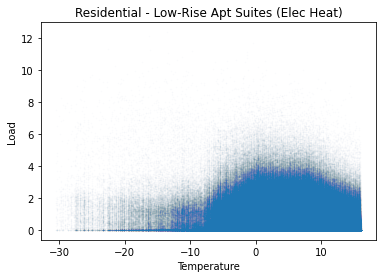

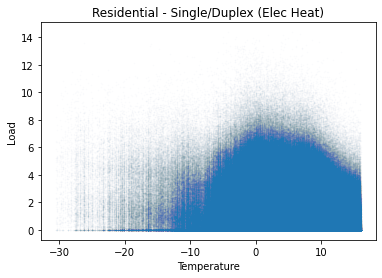

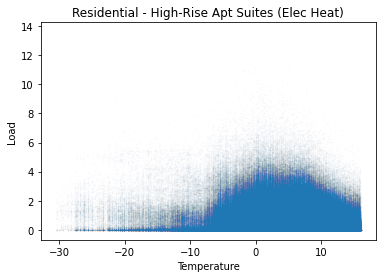

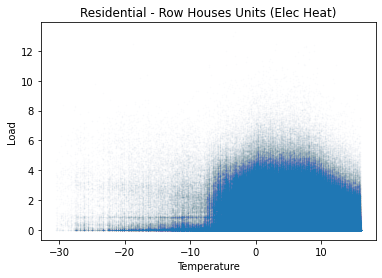

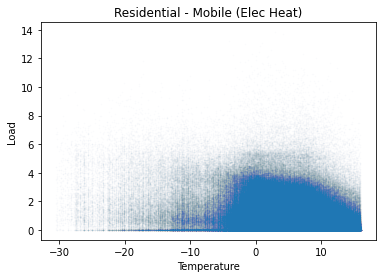

In [4]:
for ht, df in zip(ht_df.keys(), ht_df.values()):
    df.plot.scatter(x='Temperature', y='Load', title = ht, s = 1, alpha = 0.01)
    plt.show()

In [5]:
reg_dic = {}
for ht, df in zip(ht_df.keys(), ht_df.values()):
    regr = linear_model.LinearRegression()
    X = df['Temperature'].values.reshape((-1,1))
    Y = df['Load'].values.reshape((-1,1))
    regr.fit(X,Y)
    print(ht, regr.intercept_, regr.coef_)
    reg_dic[ht] = regr

Residential - Low-Rise Apt Suites (Elec Heat) [0.63100505] [[-0.0362967]]
Residential - Single/Duplex (Elec Heat) [1.77716806] [[-0.09662023]]
Residential - High-Rise Apt Suites (Elec Heat) [0.61853176] [[-0.03439094]]
Residential - Row Houses Units (Elec Heat) [1.13610787] [[-0.05866962]]
Residential - Mobile (Elec Heat) [1.3020396] [[-0.06206181]]


Let's have a look at how the results look for Single/Duplex on Vancouver Island.

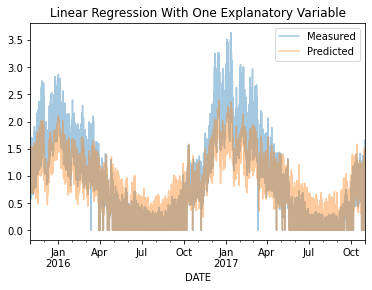

In [6]:
reg = 'VI'
ht = 'Residential - Single/Duplex (Elec Heat)'
house_ids = [str(_) for _ in df_meta[(df_meta.SITECODE == ht) & (df_meta.REGION == reg)].ID.values]
df_dic = {
        'DATE':df_heat.index,
        'Temperature':df_temp[df_temp.index.isin(df_heat.index)][reg],
        'Measured':df_heat[house_ids].values.mean(axis=1)
}
_df = pd.DataFrame.from_dict(df_dic)
_pred = reg_dic[ht].predict(_df.Temperature.values.reshape((-1,1)))
_df['Predicted'] = _pred
threshold = 16
_to_zero = _df[_df.Temperature > threshold].index
_df.loc[_to_zero, 'Predicted'] = 0
_df.plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');


Let's look at some prediction statistics... we'll first need to define a function that spits out some common ones.

In [7]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    if min(y_true.min(), y_pred.min()) >= 0:
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    if min(y_true.min(), y_pred.min()) >= 0:
        print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [8]:
regression_results(_df.Measured, _df.Predicted)

explained_variance:  0.7957
mean_squared_log_error:  0.0282
r2:  0.7815
MAE:  0.2559
MSE:  0.132
RMSE:  0.3633


Okay, so it is generally 'ok'. As we'd expect, it's capturing the seasonal trends. Let's take a closer look at the first week:

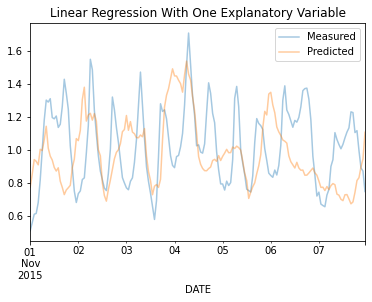

In [9]:
_df[:7*24].plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');

Okay, not so great here. The diurnal trends are not well modelled.


Let's add the hour-of-the-day as an explanatory variable and see if that helps.

In [10]:
hours = ['H'+str(_) for _ in range(23)]
for ht, df in zip(ht_df.keys(), ht_df.values()):
    df[hours] = 0
    for h in range(23):
        _idx = df.index[df.DATE.dt.hour == h]
        df.loc[_idx, 'H'+str(h)] = 1
df.tail()

,DATE,Load,Temperature,H0,H1,H2,H3,H4,H5,H6,...,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22
1107682,2017-10-31 19:00:00,0.000000,7.479265,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1107683,2017-10-31 20:00:00,0.013481,7.034063,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1107684,2017-10-31 21:00:00,0.256182,5.905504,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1107685,2017-10-31 22:00:00,0.978000,5.048809,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1107686,2017-10-31 23:00:00,1.453917,3.271780,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
reg_dic = {}
for ht, df in zip(ht_df.keys(), ht_df.values()):
    regr = linear_model.LinearRegression()
    explanatory = ['Temperature'] + hours
    X = df[explanatory].values
    Y = df['Load'].values.reshape((-1,1))
    regr.fit(X,Y)
    reg_dic[ht] = regr

explained_variance:  0.8723
r2:  0.8573
MAE:  0.2051
MSE:  0.0862
RMSE:  0.2936


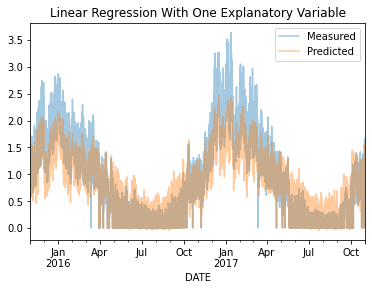

In [12]:
reg = 'VI'
ht = 'Residential - Single/Duplex (Elec Heat)'
house_ids = [str(_) for _ in df_meta[(df_meta.SITECODE == ht) & (df_meta.REGION == reg)].ID.values]
df_dic = {
        'DATE':df_heat.index,
        'Temperature':df_temp[df_temp.index.isin(df_heat.index)][reg],
        'Measured':df_heat[house_ids].values.mean(axis=1)
}
_df = pd.DataFrame.from_dict(df_dic)
_df[hours] = 0
for h in range(23):
    _idx = _df.index[_df.DATE.dt.hour == h]
    _df.loc[_idx, 'H'+str(h)] = 1

_pred = reg_dic[ht].predict(_df[explanatory].values)
_df['Predicted'] = _pred
threshold = 16
_to_zero = _df[_df.Temperature > threshold].index
_df.loc[_to_zero, 'Predicted'] = 0
_df.plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');
regression_results(_df.Measured, _df.Predicted)

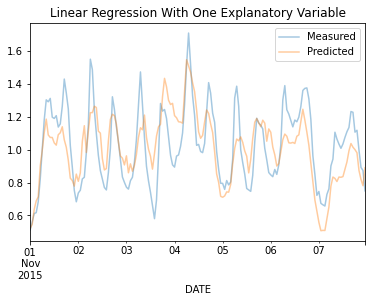

In [13]:
_df[:7*24].plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');


Okay, so we've improved on the diurnal bits. In particular, for the year the RMSE dropped from 0.1357 to 0.094. We can go a step further by including an explanatory variable indicating whether the hour in question belongs to a working day or a non-working day (Weekend/holiday).

In [14]:
cal = calendar()
holidays = cal.holidays(start=df_heat.index.values.min(),
                        end=df_heat.index.values.max())
holidays = pd.Series(holidays)

for ht, df in zip(ht_df.keys(), ht_df.values()):
    df['Workday'] = 1
    hlds = df.DATE.isin(holidays)
    wknds = df.DATE.dt.dayofweek.isin([5,6])
    df.loc[hlds, 'Workday'] = 0
    df.loc[wknds, 'Workday'] = 0

reg_dic = {}
for ht, df in zip(ht_df.keys(), ht_df.values()):
    regr = linear_model.LinearRegression()
    explanatory = ['Temperature'] + hours + ['Workday']
    X = df[explanatory].values
    Y = df['Load'].values.reshape((-1,1))
    regr.fit(X,Y)
    reg_dic[ht] = regr

explained_variance:  0.8724
r2:  0.8574
MAE:  0.2048
MSE:  0.0862
RMSE:  0.2935


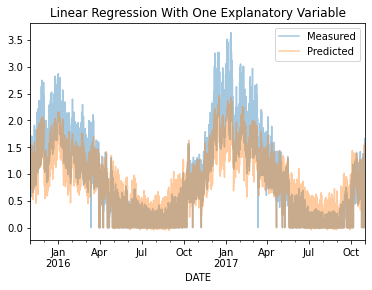

In [15]:
reg = 'VI'
ht = 'Residential - Single/Duplex (Elec Heat)'
house_ids = [str(_) for _ in df_meta[(df_meta.SITECODE == ht) & (df_meta.REGION == reg)].ID.values]
df_dic = {
        'DATE':df_heat.index,
        'Temperature':df_temp[df_temp.index.isin(df_heat.index)][reg],
        'Measured':df_heat[house_ids].values.mean(axis=1)
}
_df = pd.DataFrame.from_dict(df_dic)
_df[hours] = 0
for h in range(23):
    _idx = _df.index[_df.DATE.dt.hour == h]
    _df.loc[_idx, 'H'+str(h)] = 1
    
_df['Workday'] = 1
hlds = _df.DATE.isin(holidays)
wknds = _df.DATE.dt.dayofweek.isin([5,6])
_df.loc[hlds, 'Workday'] = 0
_df.loc[wknds, 'Workday'] = 0

_pred = reg_dic[ht].predict(_df[explanatory].values)
_df['Predicted'] = _pred
threshold = 16
_to_zero = _df[_df.Temperature > threshold].index
_df.loc[_to_zero, 'Predicted'] = 0
_df.plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');
regression_results(_df.Measured, _df.Predicted)

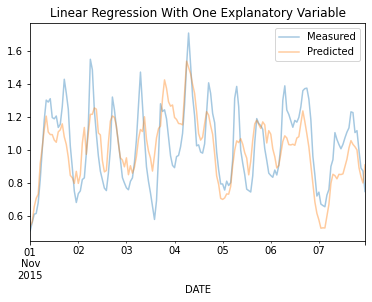

In [16]:
_df[:7*24].plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');


So that improved things, but very minimally. 

The issue that remains that it seems that the temperature response is not pronounced enough. This is more than likely because the heating response to temperature is not linearly proportional. It may be a good idea to do some fractional polynomial regression... let'd code up a basic version of this to see whether it improves things. To do this, we'll add T^N for N=(-3,-2,-1,2,3) and log(T) as explanatory variables. Instead of using the Temperature measurement here, we'll use the temperature deviation from the threshold so that we're dealing w/ strictly positive numbers. 


In [17]:
Tcols = []
for ht, df in zip(ht_df.keys(),ht_df.values()):
    df['T'] = (threshold + 1) - df.Temperature # add the +1, because we don't want values of 0 here. Otherwise, 
                                               # the log function will give back -inf
    for val in [-3, -2, -1, -0.5, 0.5, 2, 3]:
        df['T'+str(val)] = df['T']**val   
    df['Tlog'] = np.log(df['T'])

Tcols = []
for val in [-3, -2, -1, -0.5, 0.5, 2, 3]:
    Tcols.append('T'+str(val))
Tcols.append('Tlog')


In [18]:
reg_dic = {}
for ht, df in zip(ht_df.keys(), ht_df.values()):
    regr = linear_model.LinearRegression()
    explanatory = ['T'] + hours + ['Workday'] + Tcols
    X = df[explanatory].values
    Y = df['Load'].values.reshape((-1,1))
    regr.fit(X,Y)
    reg_dic[ht] = regr

/home/cameron/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


explained_variance:  0.9006
r2:  0.8889
MAE:  0.1755
MSE:  0.0671
RMSE:  0.2591


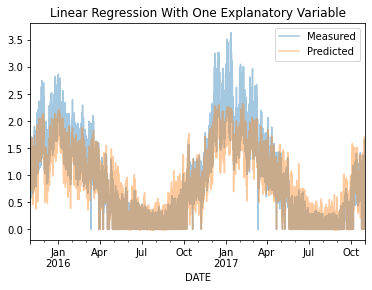

In [19]:
reg = 'VI'
ht = 'Residential - Single/Duplex (Elec Heat)'
house_ids = [str(_) for _ in df_meta[(df_meta.SITECODE == ht) & (df_meta.REGION == reg)].ID.values]
df_dic = {
        'DATE':df_heat.index,
        'Temperature':df_temp[df_temp.index.isin(df_heat.index)][reg],
        'Measured':df_heat[house_ids].values.mean(axis=1)
}
_df = pd.DataFrame.from_dict(df_dic)
_df[hours] = 0
for h in range(23):
    _idx = _df.index[_df.DATE.dt.hour == h]
    _df.loc[_idx, 'H'+str(h)] = 1
    
_df['Workday'] = 1
hlds = _df.DATE.isin(holidays)
wknds = _df.DATE.dt.dayofweek.isin([5,6])
_df.loc[hlds, 'Workday'] = 0
_df.loc[wknds, 'Workday'] = 0

_df['T'] = (threshold + 1) - _df.Temperature 
_to_zero = _df[_df.Temperature > threshold].index
for val in [-3, -2, -1, -0.5, 0.5, 2, 3]:
    _df['T'+str(val)] = _df['T']**val   
_df['Tlog'] = np.log(_df['T'])
_df = _df.fillna(0)
_pred = reg_dic[ht].predict(_df[explanatory].values)
_df['Predicted'] = _pred
threshold = 16
_df.loc[_to_zero, 'Predicted'] = 0
_df.plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');
regression_results(_df.Measured, _df.Predicted)

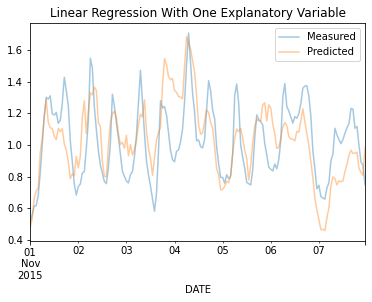

In [21]:
_df[:7*24].plot.line(x='DATE', y = ['Measured', 'Predicted'], alpha = 0.4,
              title='Linear Regression With One Explanatory Variable');


## To conclude
I hope this was somewhat helpful in illustrating how to work with this dataset. Of course we could have went further and done a better job; this was just an illustrative exercise. 

To summarize:
- by using the Temperature as the only explanatory variable, we obtained:
    - explained_variance:  0.7957
    - r2:  0.7815
    - RMSE:  0.3633
        
- by adding time of day, workday, and fractional polynomial terms of T, we obtained:
  - explained_variance:  0.9006
  - r2:  0.8889
  - RMSE:  0.2591
    

Some further ideas to improve the model:
- lagged temperature (i.e. the temperature in the previous hour)
- lagged heating demand. This would create an 'auto-regressive' model. More complicated...

There are a ton of resources online on how to use python/pandas. I'm always happy to answer questions, too... Best of luck!